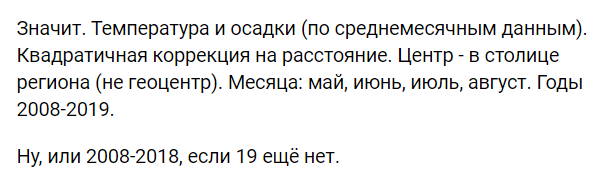

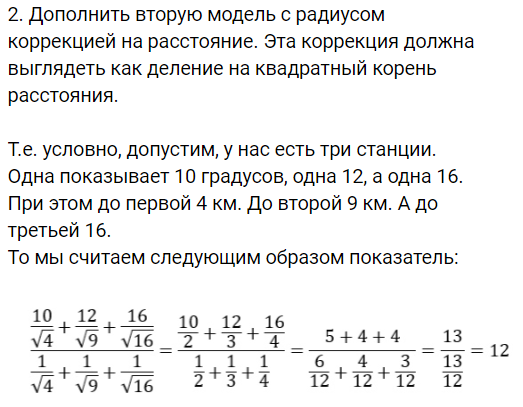

In [1]:
import pandas as pd
import numpy as np
from geopy.distance import distance # какая-то узкоспециализированная библиотека, чтоб считать расстояние в км зная широту и долготу

In [2]:
# задаём радиус, внутри которого будут считаться станции (в километрах)
radius = 500

In [3]:
# Если мы хотим координаты ГЕОЦЕНТРА то True
# Если СТОЛИЦЫ то False
center = False

In [4]:
# шаблон для данных
template = pd.read_excel('Shablon_dlya_dannykh.xlsx')
# фрагмент
template.head()

,Код региона,Регион,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22.0,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28.0,Амурская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29.0,Архангельская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30.0,Астраханская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Скачиваем данные. Архив я извлекла в папку, папку с названием типа "wr46103" переименовала (все равно у вас названия были бы другие), но внутри названия не меняла. Если кто-то захочет запустить этот код у себя, разумеется, путь к файлам надо будет поменять на то, как они названы и где лежат на используемом компе


In [5]:
temp = pd.read_fwf("temp_4_months\wr46103.txt", header = None)
temp.columns = ['code_station', 'year', 'may', 'june', 'july', 'august']
temp.head()

,code_station,year,may,june,july,august
0,20046,2008,NaN,NaN,NaN,NaN
1,20046,2009,-8.9,-1.2,0.6,0.2
2,20046,2010,-5.3,-1.2,0.5,NaN
3,20046,2011,-6.9,-0.4,0.6,0.6
4,20046,2012,-6.8,-0.7,1.0,0.9


In [6]:
rain = pd.read_fwf("rain_4_months\wr46099.txt", header = None)
rain.columns = ['code_station', 'year', 'may', 'june', 'july', 'august']
rain.head()

,code_station,year,may,june,july,august
0,20046,2008,NaN,NaN,NaN,NaN
1,20046,2009,15.6,7.8,33.6,10.6
2,20046,2010,5.2,0.9,8.4,NaN
3,20046,2011,23.2,5.2,11.8,6.9
4,20046,2012,17.4,22.2,20.1,16.1


Прекрасно, теперь берем табличку про станции, отсюда будем знать корды станций

In [7]:
stations = pd.read_csv("cords_stations.csv")
# фрагмент 
stations.head()

,Широта,Долгота,Подпись,Номер метки,Код станции,Unnamed: 5,Код региона
0,"80,62","58,05","Им.Э.Т.Кренкеля, ГМО",1,20046,NaN,29
1,"79,50","76,98",Визе,2,20069,NaN,24
2,"79,55","90,62",Голомянный,3,20087,NaN,24
3,"78,07","14,25",Баренцбург,4,20107,Норвегия,0
4,"77,17","96,43",Русский,5,20289,NaN,24


In [8]:
# сокращаем чисто для красоты
stations = stations[['Код станции', 'Широта', 'Долгота']]

# меняю широту и долготу в числовой формат
stations['Широта'] = stations['Широта'].replace(',','.', regex=True).values.astype(float)
stations['Долгота'] = stations['Долгота'].replace(',','.', regex=True).values.astype(float)

stations.head()

,Код станции,Широта,Долгота
0,20046,80.62,58.05
1,20069,79.50,76.98
2,20087,79.55,90.62
3,20107,78.07,14.25
4,20289,77.17,96.43


А теперь табличку с регионами, из которой мы узнаем координаты центра/столицы региона

In [9]:
regions = pd.read_csv("cords_regions.csv")
regions.head()

,Код,Наименование,Широта столицы,Долгота столицы,Широта геоцентра,Долгота геоцентра
0,22,Алтайский край,53.3529,83.67371,51.79362,82.67585
1,28,Амурская область,50.27277,127.5404,54.6035,127.48017
2,29,Архангельская область,64.54725\n,40.56015,63.28528,42.58841
3,30,Астраханская область,46.3588,48.05993,46.13211,48.06101
4,31,Белгородская область,50.59971,36.59826,50.71069,37.75333


In [10]:
# сокращаем табличку, оставляем только нужные координаты, или центра или столицы

regions = regions.replace('-', np.nan, regex=True)
regions = regions[['Код','Широта столицы','Долгота столицы','Широта геоцентра', 'Долгота геоцентра']].apply(pd.to_numeric)

if center:
    regions = regions[["Код", "Широта геоцентра", "Долгота геоцентра"]]
    regions.columns = ["Код", "Широта", "Долгота"]
else:
    regions = regions[["Код", "Широта столицы", "Долгота столицы"]]
    regions.columns = ["Код", "Широта", "Долгота"]

regions.head()

,Код,Широта,Долгота
0,22,53.35290,83.67371
1,28,50.27277,127.54040
2,29,64.54725,40.56015
3,30,46.35880,48.05993
4,31,50.59971,36.59826


Чтоб алгоритм не пересчитывал расстояния каждый раз, делаем таблицу расстояний (кстати, станций в этом списке больше чем нужно, но тут проще считать как есть чем пытаться исключать. Единственная проблема - в списке могут присутствовать не все станции данные нам, но тут что поделать)

In [11]:
# я временно заменяю координаты байконура на 0 и 0, чисто чтоб расстояния дальше считались корректно
regions.loc[14,"Широта"] = 0
regions.loc[14,"Долгота"] = 0

In [12]:
# считается долго
distance_table = regions.apply(lambda x: stations.apply(lambda y: distance((x["Широта"], x["Долгота"]), (y["Широта"], y["Долгота"])).km, axis=1), axis=1)

# украшательства
distance_table.columns = stations["Код станции"]
distance_table.insert(0, 'Код региона', regions["Код"])
distance_table = distance_table.set_index("Код региона")
distance_table 

Код станции,20046,20069,20087,20107,20289,20292,20476,20667,20674,20744,...,38750,38763,38836,38880,38895,38927,38933,38954,38974,38987
Код региона,,,,,,,,,,,,,,,,,,,,,
22,3171.562587,2926.169557,2932.501900,3800.444401,2706.677619,2840.326823,2470.547847,2315.260670,2250.764373,2578.637404,...,2904.642763,2623.626273,2001.324110,2587.303763,2408.203698,2194.594543,2071.966561,1996.584926,2554.451513,2611.005991
28,4161.620718,3777.919706,3556.189309,5081.625683,3275.118938,3209.232483,3293.642475,3719.431503,3410.095031,4284.188999,...,5854.777896,5568.860317,4725.722261,5496.341492,5253.223150,4919.612235,4773.498695,4601.571634,5393.592970,5400.953980
29,1866.914289,2013.292459,2263.594579,1742.957779,2337.568917,2530.791006,2115.701742,1508.487575,1826.740218,1000.205137,...,3134.283454,3024.783456,3430.344639,3180.373824,3320.506003,3514.663583,3504.823051,3633.522277,3407.080549,3569.987554
30,3837.753623,3873.160969,4068.441247,3817.447539,4030.353846,4229.260902,3757.903232,3201.979701,3425.892025,2907.436931,...,1089.379804,1059.892432,1904.493016,1258.248862,1517.775980,1883.724846,1950.642890,2167.596713,1545.578348,1717.301745
31,3437.406931,3569.829032,3808.505269,3196.182855,3845.860302,4044.756570,3598.399682,2993.600739,3280.684478,2552.917331,...,1988.574275,2012.042090,2854.256289,2216.693805,2485.823485,2846.240859,2905.329469,3113.399579,2509.421184,2680.362370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,4185.436832,4236.191513,4437.666755,4113.097438,4407.159426,4606.564117,4136.069278,3573.510666,3804.199413,3257.204585,...,935.615386,1010.606978,2008.819007,1221.712417,1533.112882,1949.739238,2041.352757,2274.319088,1523.668054,1687.437235
21,2757.485417,2815.503313,3026.980127,2749.225045,3020.568469,3221.059556,2757.948368,2172.849825,2429.873417,1829.154483,...,2126.924900,2018.521601,2519.486222,2179.329531,2340.349124,2577.905382,2588.409920,2746.767774,2417.408214,2583.848600
87,3449.847821,3232.473403,2977.988950,4112.843107,2936.120857,2736.075585,3194.645706,3789.041958,3522.971195,4241.437986,...,7671.955216,7427.262234,7005.968322,7458.044392,7354.911121,7196.536087,7078.187656,7000.080107,7498.506295,7582.160113


In [13]:
distance_table.to_excel('distance_table.xlsx', encoding = 'utf-8')

In [13]:
# возвращаю на место наны 
regions.loc[14,"Широта"] = np.nan
regions.loc[14,"Долгота"] = np.nan
regions.loc[14] # проверочка

Код        99.0
Широта      NaN
Долгота     NaN
Name: 14, dtype: float64

In [14]:
# проставляю в строке байконура radius + 1 чтобы он не считался. В самом конце надо не забыть вместо нулей поставить наны
distance_table.loc[99] = [radius + 1] * 600
# примерчик, выводим станции для региона 
distance_table.loc[99]

Код станции
20046    501.0
20069    501.0
20087    501.0
20107    501.0
20289    501.0
         ...  
38927    501.0
38933    501.0
38954    501.0
38974    501.0
38987    501.0
Name: 99, Length: 600, dtype: float64

In [15]:
# пример, список станций внутри радиуса для региона 83
code = 83
a = distance_table.loc[code]
b = a.loc[a < 500]
b

Код станции
20946    390.636028
22095    264.311581
22165    421.209764
22271    379.481745
22292    187.731646
22471    439.325143
22583    407.728628
23022    417.866239
23114    139.716133
23205      5.641510
23219    277.180059
23220    475.495172
23324    360.802839
23405    252.656295
23412    252.981138
23418    335.662544
23514    366.281219
Name: 83, dtype: float64

Теперь, имея таблицу расстояний, бахнем долгий сложный подсчет. Для каждого региона должны получить по одному числу в месяц и год

In [16]:
# тут будут лежать ответы. да, дохрена одинаковых переменных. А что поделать? Ничего.
# когда месяца было 2 было пристойно, а сейчас уже нет времени переписывать. К тому же, работает - не трогай
may_temp = pd.DataFrame(index = range(2008, 2019))
may_rain = pd.DataFrame(index = range(2008, 2019))
june_temp = pd.DataFrame(index = range(2008, 2019))
june_rain = pd.DataFrame(index = range(2008, 2019))
july_temp = pd.DataFrame(index = range(2008, 2019))
july_rain = pd.DataFrame(index = range(2008, 2019))
august_temp = pd.DataFrame(index = range(2008, 2019))
august_rain = pd.DataFrame(index = range(2008, 2019))

Тут дальше код, немного сложный для понимания даже с коментами. Если кто то захочет его разобрать - по одной строчке просмотрите какие именно данные где лежат, в каком формате и т.д. для одного из регионов. Например поставьте i = 22 и пошагово глядите что содержат переменные

In [17]:
for i in regions["Код"]:
    
    row = distance_table.loc[i] # строка в таблице расстояний, длинной в 600
    row = row[row < radius] # теперь тут только близкие станции, длина разная от региона к региону
    nearby_stations = set(row.index) # коды близких станций
    
    # К сожалению, за какой то год какая то станция может не иметь данных. Это ужасно грустно,
    # потому что делает расчеты сложнее, мы не можем один раз посчитать знаменатель и всё.
    
    temp_stations = temp[temp['code_station'].isin(nearby_stations)] # температурные данные для близких станций
    
    nearby_stations = set(temp_stations['code_station']) # убираем таким образом станции, которых ваще нет в данных
    row = row[nearby_stations]
    
    r = 1 / np.sqrt(row) # переменная для удобства
    
    # числители, дроби которые нужно суммировать:
    # так нелепо 4 разных переменных потому что время на исходе и переписывать его нет
    
    top_may = temp_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['may']), index = x['code_station']) * r)
    top_june = temp_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['june']), index = x['code_station']) * r)
    top_july = temp_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['july']), index = x['code_station']) * r)
    top_august = temp_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['august']), index = x['code_station']) * r)
    
    # сложная схема, потому что мы не хотим чтоб в знаменателе были слагаемые, соответствующая которым станция дала nan
    may_temp = pd.concat([may_temp, \
                           top_may.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                          ], axis=1, sort=False)
    june_temp = pd.concat([june_temp, \
                           top_june.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                          ], axis=1, sort=False)
    july_temp = pd.concat([july_temp, \
                           top_july.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                          ], axis=1, sort=False)
    august_temp = pd.concat([august_temp, \
                             top_august.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                            ], axis=1, sort=False)
    

C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


спакойна, у меня тут 4 предупреждения RuntimeWarning: invalid value encountered in double_scalars, но я почти уверена что это из-за нанов

In [18]:
# теперь повторяем все абсолютно то же самое, но для осадков
for i in regions["Код"]:
    
    row = distance_table.loc[i]
    row = row[row < radius]
    nearby_stations = set(row.index)
    
    rain_stations = rain[rain['code_station'].isin(nearby_stations)]
    
    nearby_stations = set(rain_stations['code_station'])
    row = row[nearby_stations]
    
    r = 1 / np.sqrt(row)
    
    top_may = rain_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['may']), index = x['code_station']) * r)
    top_june = rain_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['june']), index = x['code_station']) * r)
    top_july = rain_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['july']), index = x['code_station']) * r)
    top_august = rain_stations.groupby(["year"]).apply(lambda x: pd.Series(data = list(x['august']), index = x['code_station']) * r)
    
    # сложная схема, потому что мы не хотим чтоб в знаменателе были слагаемые, соответствующая которым станция дала nan
    may_rain = pd.concat([may_rain, \
                           top_may.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                          ], axis=1, sort=False)
    june_rain = pd.concat([june_rain, \
                           top_june.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                          ], axis=1, sort=False)
    july_rain = pd.concat([july_rain, \
                           top_july.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                          ], axis=1, sort=False)
    august_rain = pd.concat([august_rain, \
                             top_august.apply(lambda x: np.nansum(x)/np.nansum(r[np.invert(np.isnan(x))]), axis = 1) \
                            ], axis=1, sort=False)
    

C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lkuro\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [19]:
def simple_stuff(df): # простая обработка до нужного вида
    df.insert(loc = 0, column = np.nan, value = [np.nan]*11, allow_duplicates=False)
    df.columns = [np.nan] + list(regions["Код"])
    df = df.T
    df.index.name = "Код региона"
    df.insert(loc=0, column='Регион', value=list(template['Регион']))
    df.reset_index(level=0, inplace=True)
    return df

In [20]:
may_temp = simple_stuff(may_temp)
may_rain = simple_stuff(may_rain)
june_temp = simple_stuff(june_temp)
june_rain = simple_stuff(june_rain)
july_temp = simple_stuff(july_temp)
july_rain = simple_stuff(july_rain)
august_temp = simple_stuff(august_temp)
august_rain = simple_stuff(august_rain)

july_temp

,Код региона,Регион,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22.0,Алтайский край,19.769786,17.918424,16.614624,16.731227,20.777927,18.081293,18.647714,18.893980,19.507967,17.954884,17.601808
2,28.0,Амурская область,22.111853,19.900512,20.968293,23.104737,21.684775,20.964650,20.703822,21.146916,21.213244,21.371494,21.254910
3,29.0,Архангельская область,14.413982,14.121746,18.373583,17.535449,15.292487,15.928413,15.174287,11.832313,18.327750,16.349442,18.551765
4,30.0,Астраханская область,24.610487,25.218930,27.555446,27.187926,24.802015,23.993695,24.501827,25.064992,24.680208,25.513894,26.956478
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,20.0,Чеченская Республика,22.574548,22.563051,24.809860,24.493720,22.236800,21.860186,22.524957,23.123560,22.507611,23.722124,25.127446
83,21.0,Чувашская Республика,19.565486,18.546617,24.238908,21.995358,20.134780,19.483730,17.918124,17.059230,20.815924,18.239671,20.825777
84,87.0,Чукотский автономный округ,9.832799,8.228543,11.791766,11.091818,10.103214,11.289372,13.868720,13.419267,12.863004,12.340449,NaN
85,89.0,Ямало-Ненецкий автономный округ,15.514501,13.439239,12.645148,11.310883,15.593927,17.836356,10.662131,12.295147,19.267749,16.912728,16.639982


In [21]:
may_temp.to_excel('may_temp.xlsx', index = False, encoding = 'utf-8')
may_rain.to_excel('may_rain.xlsx', index = False, encoding = 'utf-8')
june_temp.to_excel('june_temp.xlsx', index = False, encoding = 'utf-8')
june_rain.to_excel('june_rain.xlsx', index = False, encoding = 'utf-8')
july_temp.to_excel('july_temp.xlsx', index = False, encoding = 'utf-8')
july_rain.to_excel('july_rain.xlsx', index = False, encoding = 'utf-8')
august_temp.to_excel('august_temp.xlsx', index = False, encoding = 'utf-8')
august_rain.to_excel('august_rain.xlsx', index = False, encoding = 'utf-8')

In [22]:
# Проверяю что в байконуре наны
july_temp.head(18)

,Код региона,Регион,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22.0,Алтайский край,19.769786,17.918424,16.614624,16.731227,20.777927,18.081293,18.647714,18.893980,19.507967,17.954884,17.601808
2,28.0,Амурская область,22.111853,19.900512,20.968293,23.104737,21.684775,20.964650,20.703822,21.146916,21.213244,21.371494,21.254910
3,29.0,Архангельская область,14.413982,14.121746,18.373583,17.535449,15.292487,15.928413,15.174287,11.832313,18.327750,16.349442,18.551765
4,30.0,Астраханская область,24.610487,25.218930,27.555446,27.187926,24.802015,23.993695,24.501827,25.064992,24.680208,25.513894,26.956478
5,31.0,Белгородская область,20.410849,21.224407,25.541756,23.099050,22.094517,19.912164,21.537790,20.217028,21.809910,19.762222,21.379488
6,32.0,Брянская область,19.202278,19.421705,24.641537,22.114874,20.886771,18.750476,20.718567,18.763942,20.633859,18.109777,20.008011
7,33.0,Владимирская область,18.870614,18.662695,24.747874,22.175055,19.871122,18.668747,19.310360,17.379824,20.391039,17.581690,20.042445
8,34.0,Волгоградская область,23.728436,25.208920,27.923991,27.149381,24.807928,23.232402,23.971184,23.900121,24.337936,24.189206,25.457033
9,35.0,Вологодская область,17.765154,17.246148,23.351338,21.350735,18.606209,18.139657,18.198966,15.679782,19.811461,16.701192,19.158539
